## Visualizing all network layers

When convolutional networks are applied to biological sequence data, usually only kernels from the first convolutional layer are visualized. In brief, this works by mapping back the position of the maximum activation of a kernel to the corresponding position in the input sequence and by extracting a subsequence of the length of the kernel starting at that position. Doing this for all input sequences yields a number of subsequences, all of the same length, that can be used to compute a position-weight matrix (PWM). This method, however, can not be applied to downstream layers of the network because the max-pooling layers interrupt the direct connection to the input sequence. Sadly, we can't just get rid of max-pooling layers, because they increase the predictive performance of the network a lot.

An alternative approach is visualization by optimization. Given a trained network, it is possible to maximize the output of a specific network node (a convolutional kernel or neuron in a dense layer) with respect to an input sequence. This method has been applied before to image data (https://distill.pub/2017/feature-visualization/) and here we have adapted it for biological sequence data. In brief: starting with a single random input sequence (in the form of a PWM) we try to maximize the output of a specific network node using a l2-norm penalized gradient ascent optimization with the respect to the input sequence. This allows us to visualize what every node in the network is reacting to.

This functionality is clunky and produces fuzzy results on noisy biological data and an unprecise PWM is not very useful. Therefore a practical application for this kind of visualization is questionable. It is, however, very interesting to see what the network is learning in its different layers.

## Input Data

We will demonstrate the approach using an artifical data set. Let's start by doing some imports, by setting up a folder that will contain all our output files (you can find both input and output folder in the github repo) and by loading the prepaired data:

In [1]:
import os
from IPython.display import Image
from pysster.Data import Data
from pysster.Model import Model
from pysster import utils

output_folder = "example_artifical/"
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

c:\tools\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = Data(["data/artifical_pos.fasta.gz", "data/artifical_neg.fasta.gz"], "ACGT")
data.train_val_test_split(0.6, 0.2)
print(data.get_summary())

              class_0    class_1
all data:       10000      10000
training:        6090       5910
validation:      1912       2088
test:            1998       2002


class_0 consists of two kinds of sequences: One half (5000 sequences) contains a C and G motif and the second half (5000 sequences) contains an A and T motif. All motifs are of length 8. Below are two sequence logos showing the two kinds of sequences. In brief: C and G motif and A and T motif are always co-occurring but e.g. C and A motif are never co-occurring. class_1 sequences are completely random and contain no motifs (no logo shown).

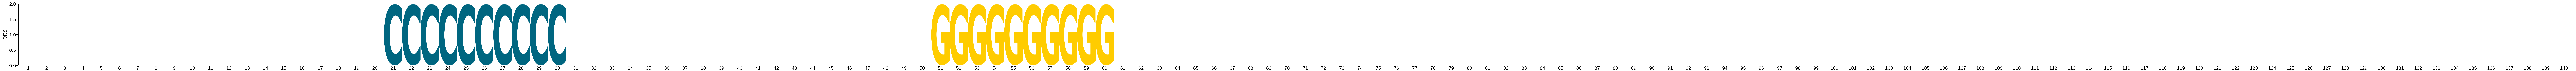

In [3]:
Image('data/pos_half1.png')

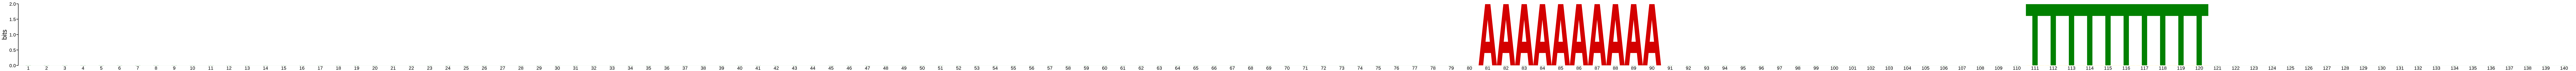

In [4]:
Image('data/pos_half2.png')

## Model Training

Let's train a small model to classify class_0 and class_1 sequences. The network has two convolutional layers (default parameter) and we set the number of kernels in each layer to be 20 (all of length 8). Our single dense layer (default parameter) has 5 neurons.

In [5]:
model = Model({'kernel_num': 20, 'kernel_len': 8, 'neuron_num': 5, 'epochs': 20}, data)
model.train(data, verbose=False)

As expected, the network can perfectly classify the artifical data:

In [6]:
predictions = model.predict(data, 'test')
labels = data.get_labels('test')
print(utils.get_performance_report(labels, predictions))

             precision    recall  f1-score   roc-auc    pr-auc          n
     class_0     0.999     1.000     0.999     1.000     1.000  |    1998
     class_1     1.000     0.999     1.000     1.000     1.000  |    2002


weighted avg     1.000     1.000     1.000     1.000     1.000  |        




Now, to visualize nodes from specific layers we need the name of the layer. We can get the names by printing an overview of the network architecture.

In [7]:
model.print_summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140, 4)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 133, 20)           660       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 20)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 66, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 59, 20)            3220      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 29, 20)            0         
__________

## Visualization of the first convolutional layer

Even though we already have visualizations for the first convolutional layer, let's start by looking at 'conv1d_1', because then we can compare the new visualizations with our "default" visualizations. We would expect them to be similar. 

The goal of the visualization by optimization is to maximize the output of a convolutional kernel, which is a vector of numbers. Therefore different objective functions are possible. We tried maximizing the sum, mean and the maximum of the vector and only maximizing the maximum gives satisfying results:

Optimize node 0...
Instructions for updating:
dim is deprecated, use axis instead
Optimize node 1...
Optimize node 2...
Optimize node 3...
Optimize node 4...
Optimize node 5...
Optimize node 6...
Optimize node 7...
Optimize node 8...
Optimize node 9...
Optimize node 10...
Optimize node 11...
Optimize node 12...
Optimize node 13...
Optimize node 14...
Optimize node 15...
Optimize node 16...
Optimize node 17...
Optimize node 18...
Optimize node 19...


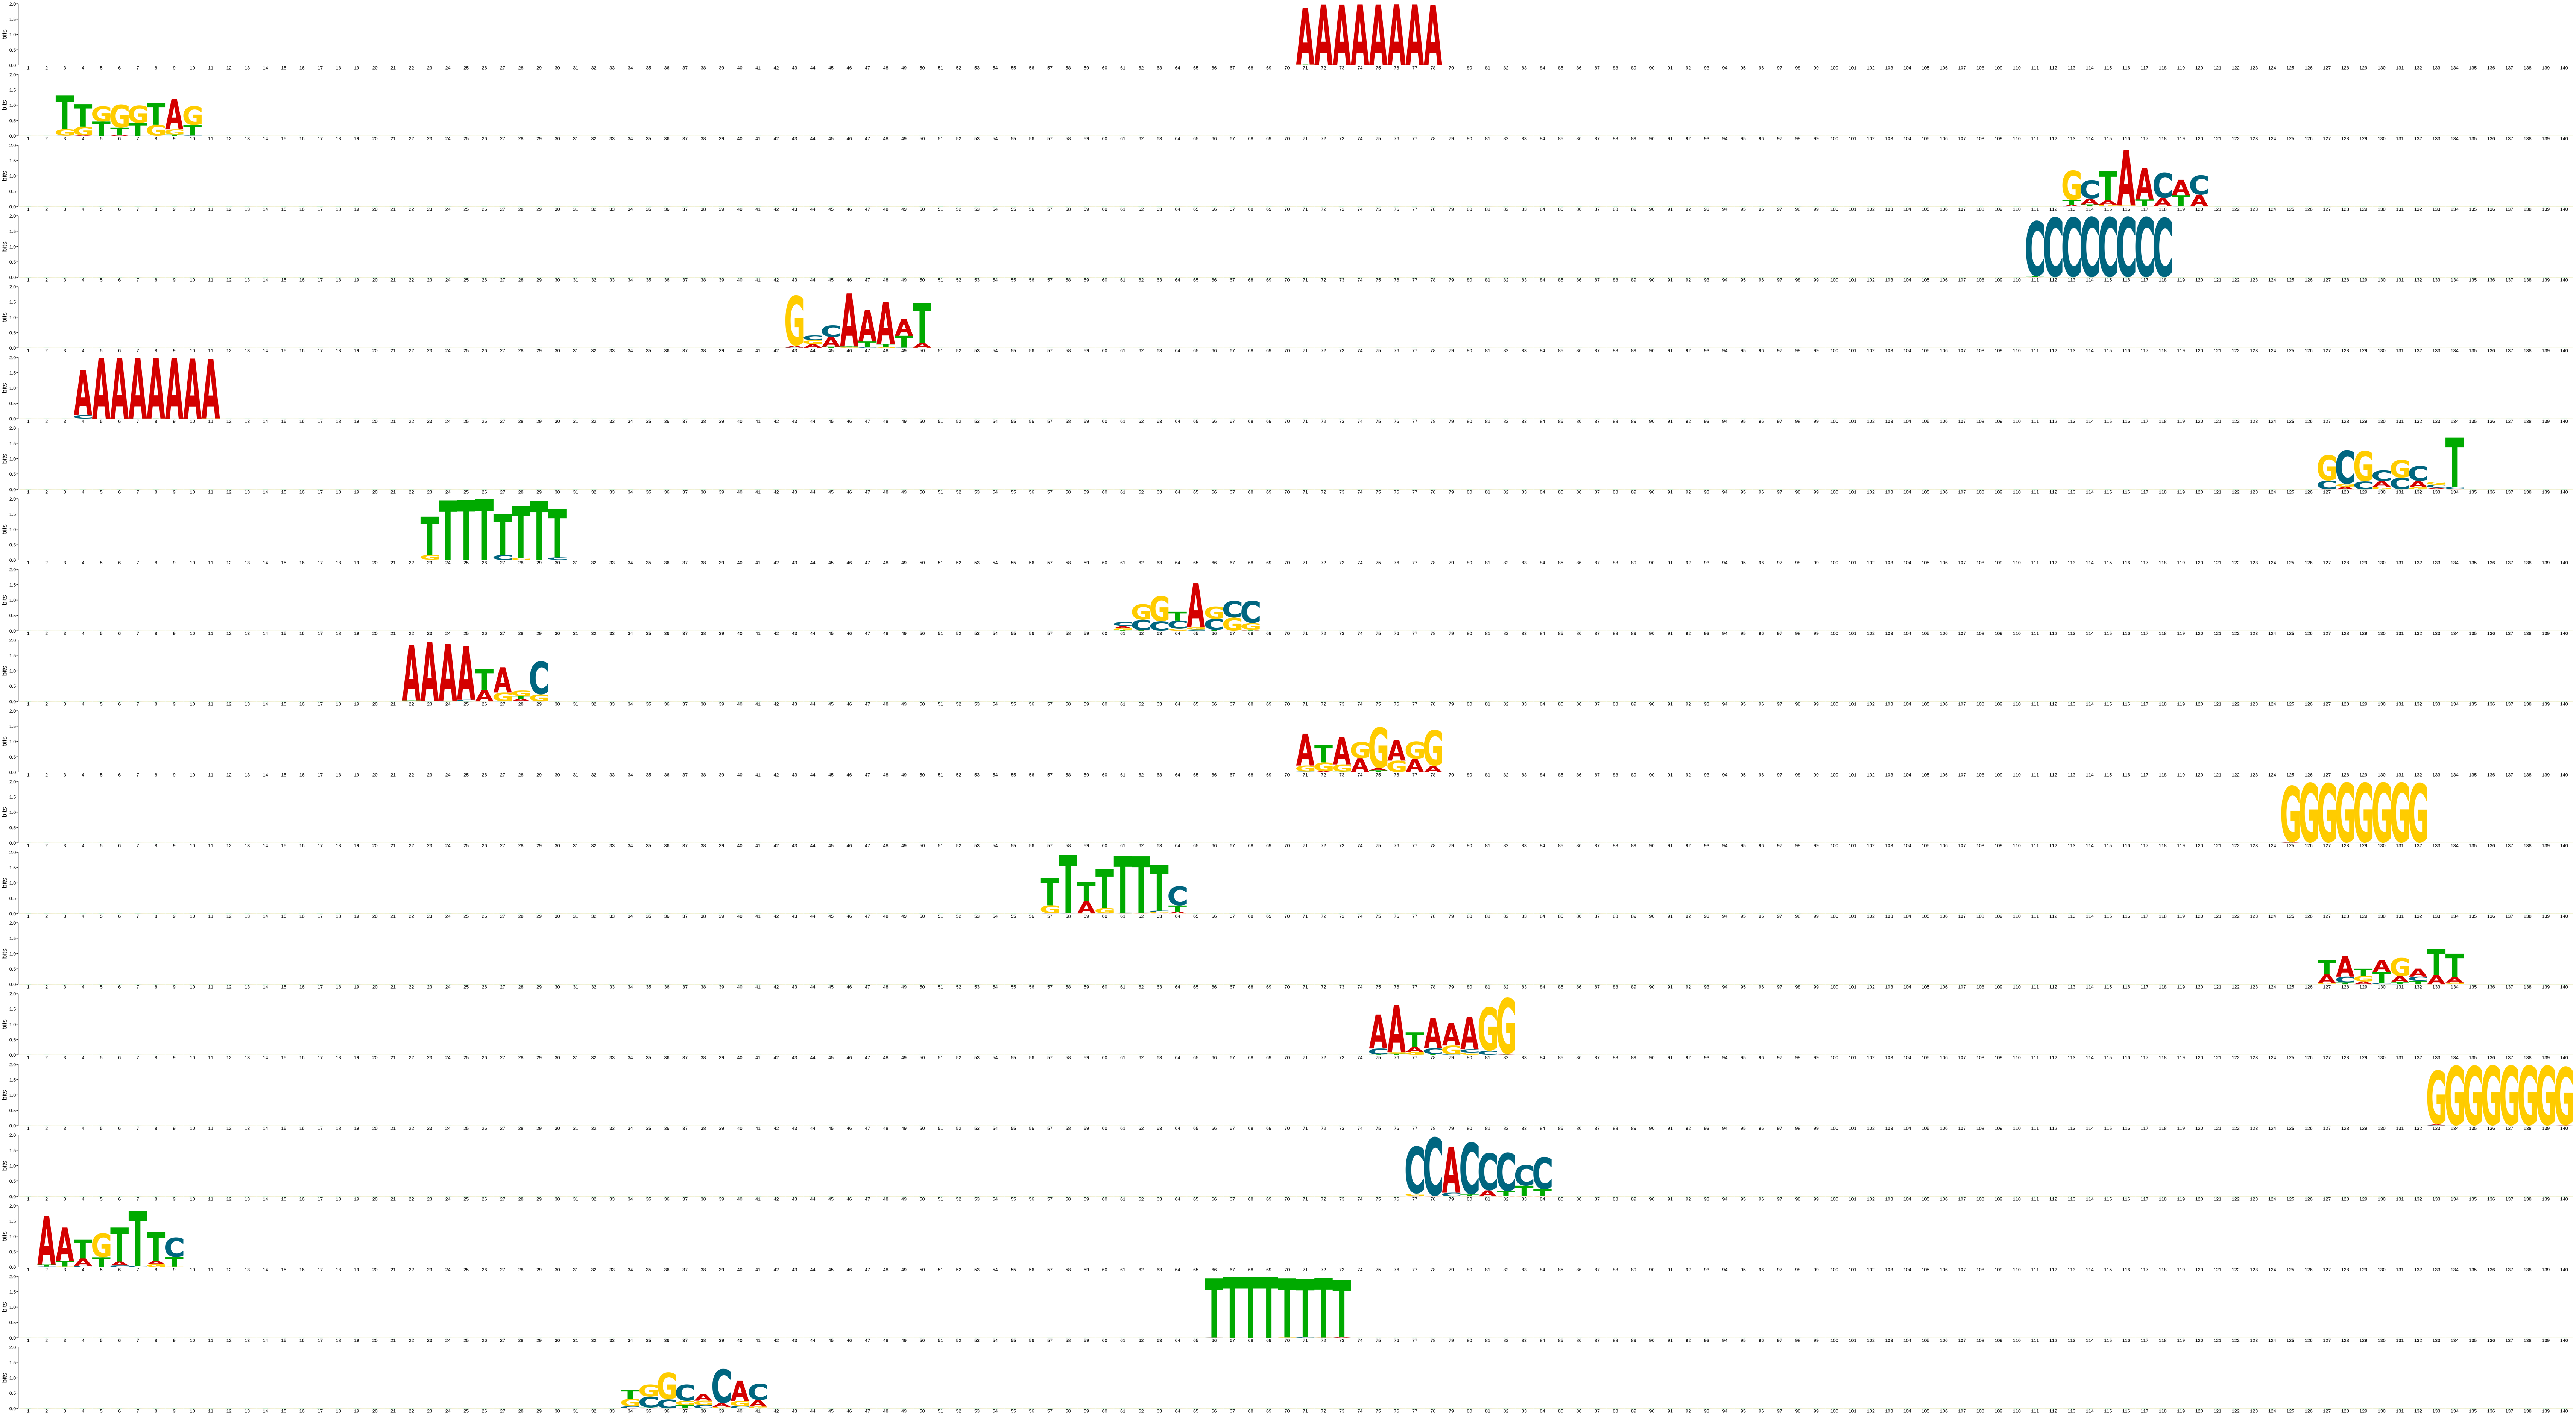

In [8]:
model.visualize_optimized_inputs(data, "conv1d_1", output_folder+'conv_1.png')
Image(output_folder+'conv_1.png')

In the image above each row represents a kernel from the layer (20 kernels). We see each of our 4 motifs at least once and when we count the number of characters with information content > 0 we always have exactly 8 characters, that is, the length of our kernels. Let's quickly apply our default visualization to the first kernel to see whether both visualizations yield the same motif:

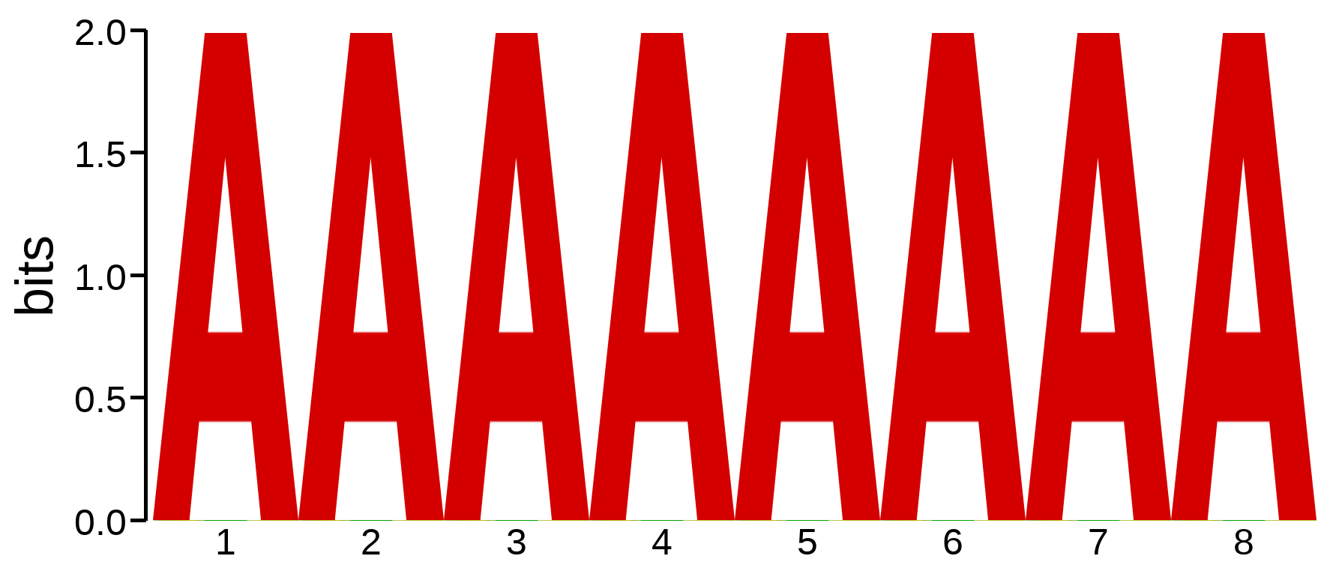

In [9]:
activations = model.get_max_activations(data, "test")
model.visualize_kernel(activations, data, 0, output_folder)
Image(output_folder+'motif_kernel_0.png')

For this simple data set we have a perfect match. We can now be a little bit more confident that applying this visualization method to the downstream layers (for which we dont have reference motifs to compare against) gives reasonable results.

Before we move on to the second layer: apparently the network is not yet learning exact motif positions, as you have probably noticed looking at the image. Indeed, running the optimization for the first layer a second time yields the same motifs at different random positions:

Optimize node 0...
Optimize node 1...
Optimize node 2...
Optimize node 3...
Optimize node 4...
Optimize node 5...
Optimize node 6...
Optimize node 7...
Optimize node 8...
Optimize node 9...
Optimize node 10...
Optimize node 11...
Optimize node 12...
Optimize node 13...
Optimize node 14...
Optimize node 15...
Optimize node 16...
Optimize node 17...
Optimize node 18...
Optimize node 19...


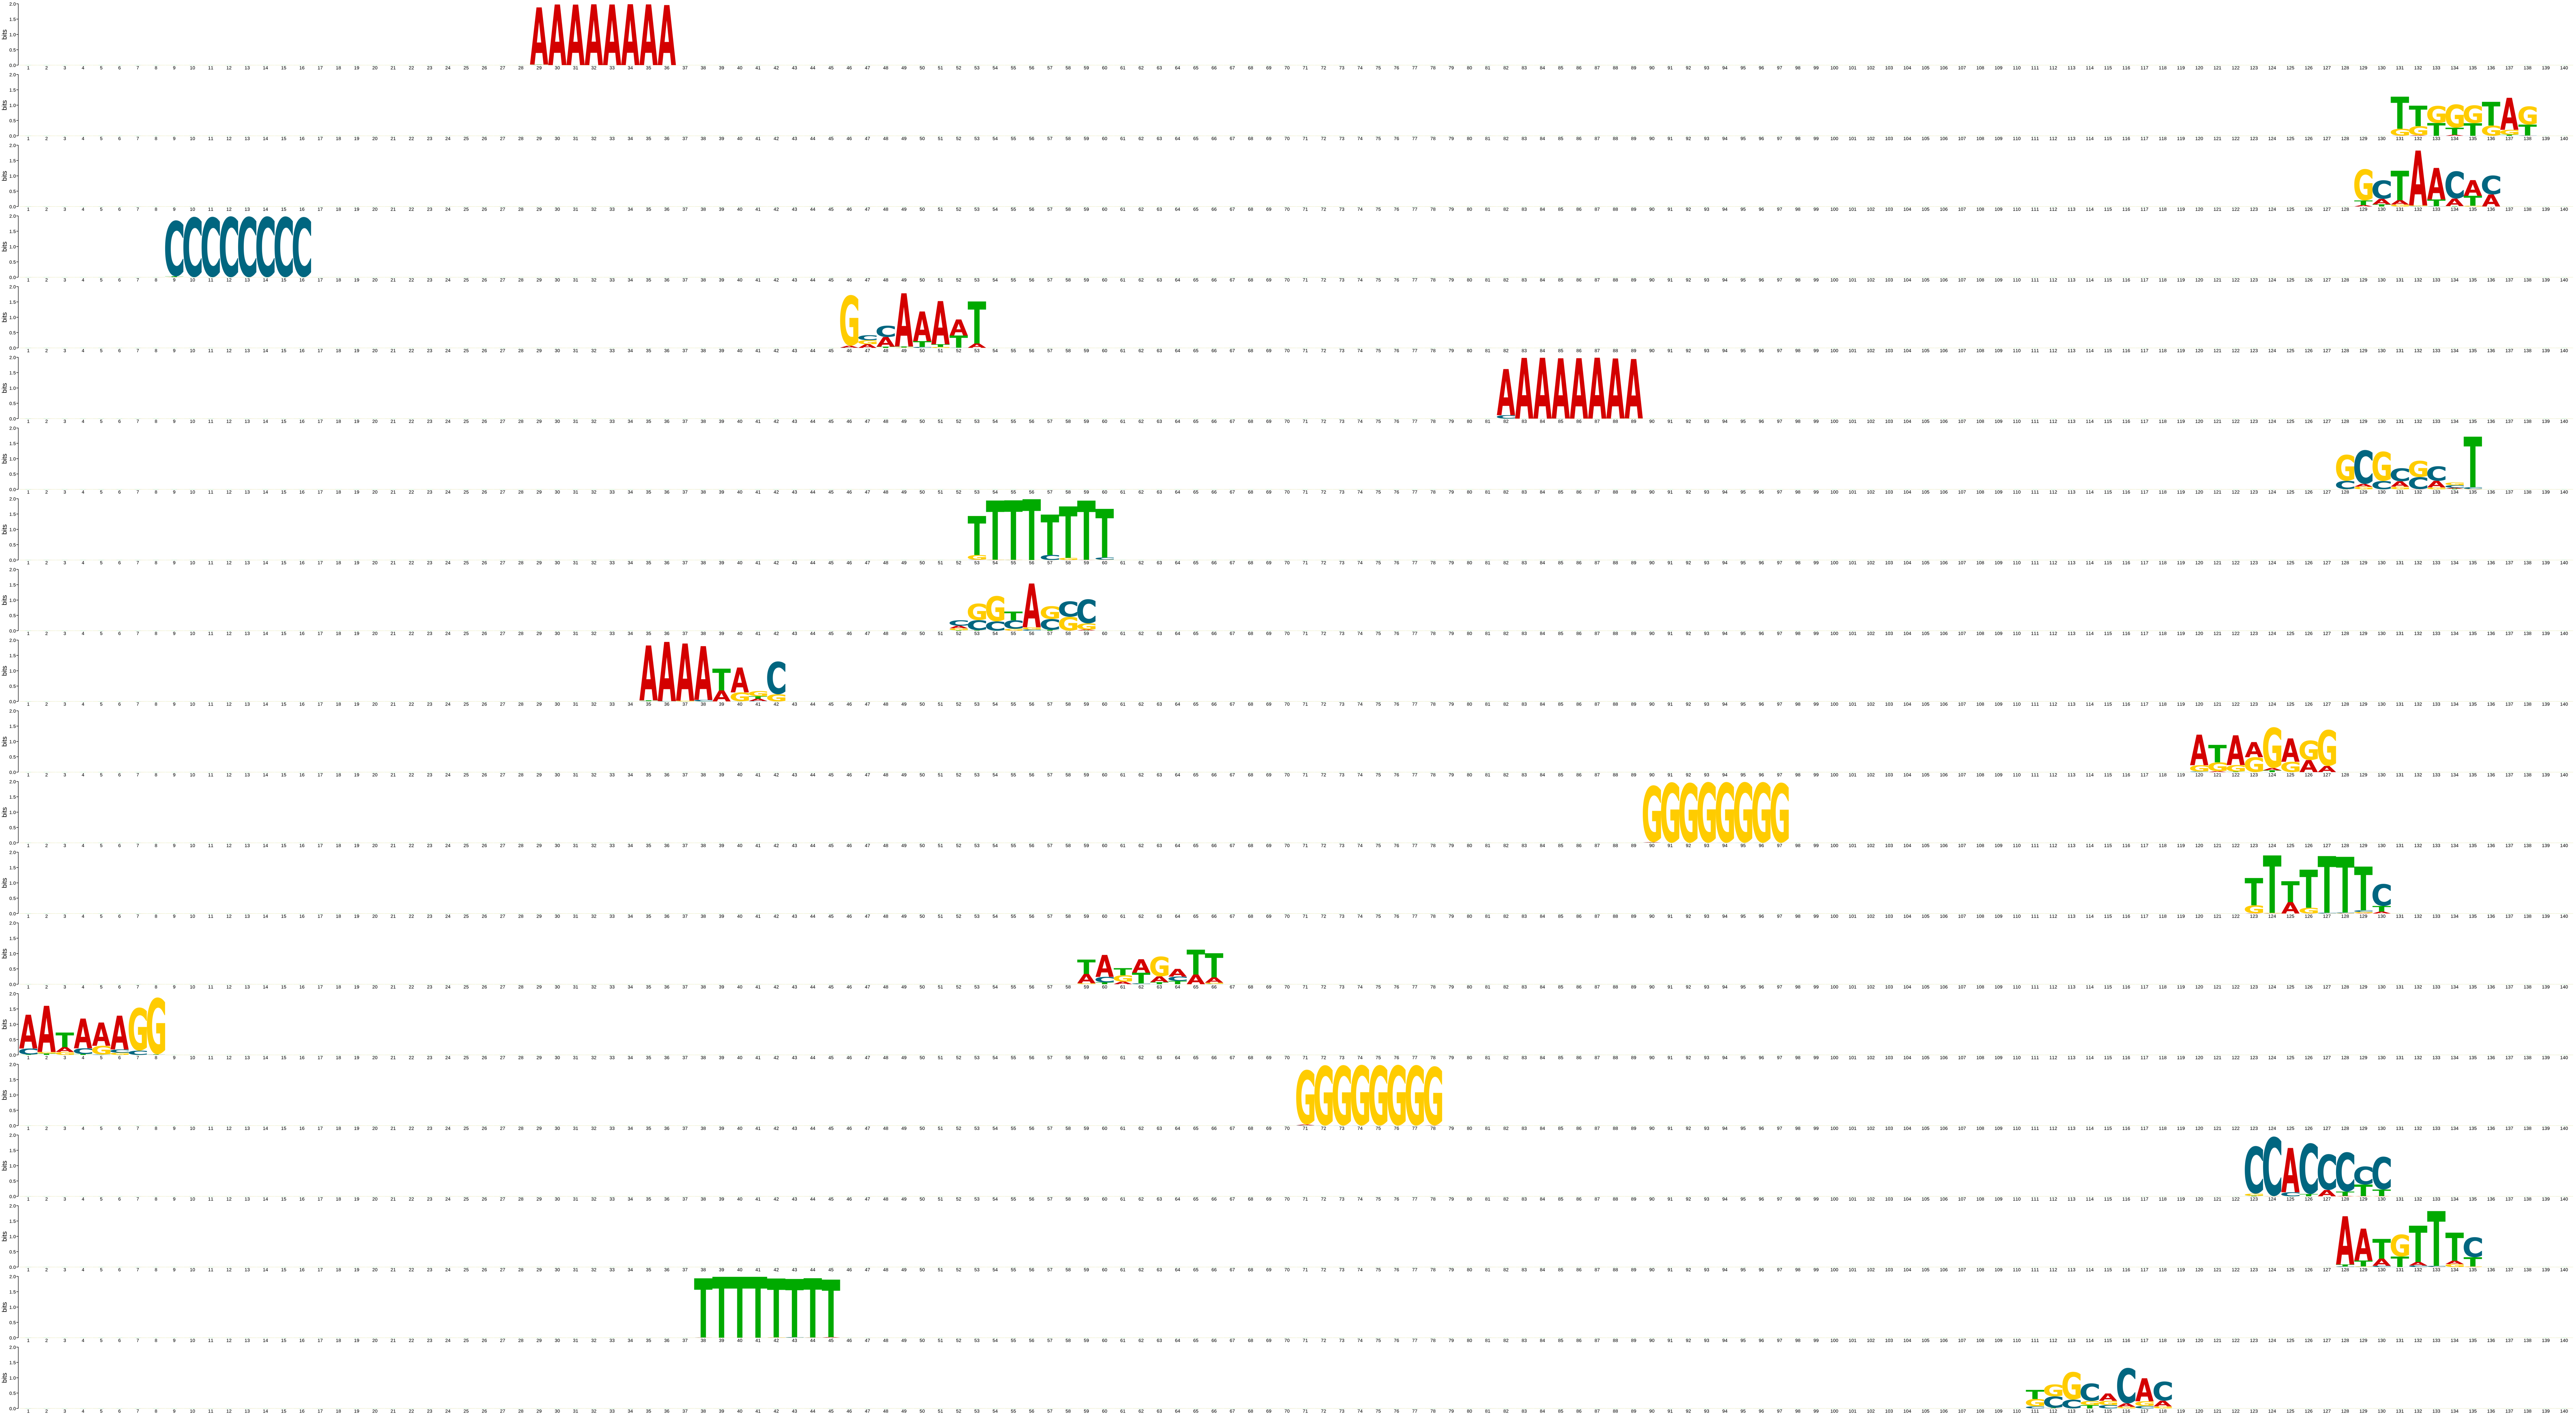

In [10]:
model.visualize_optimized_inputs(data, "conv1d_1", output_folder+'conv_1_vers2.png')
Image(output_folder+'conv_1_vers2.png')

## Visualization of the second convolutional layer

Optimizing the kernel outputs from the second convolutional layer results in this image:

Optimize node 0...
Optimize node 1...
Optimize node 2...
Optimize node 3...
Optimize node 4...
Optimize node 5...
Optimize node 6...
Optimize node 7...
Optimize node 8...
Optimize node 9...
Optimize node 10...
Optimize node 11...
Optimize node 12...
Optimize node 13...
Optimize node 14...
Optimize node 15...
Optimize node 16...
Optimize node 17...
Optimize node 18...
Optimize node 19...


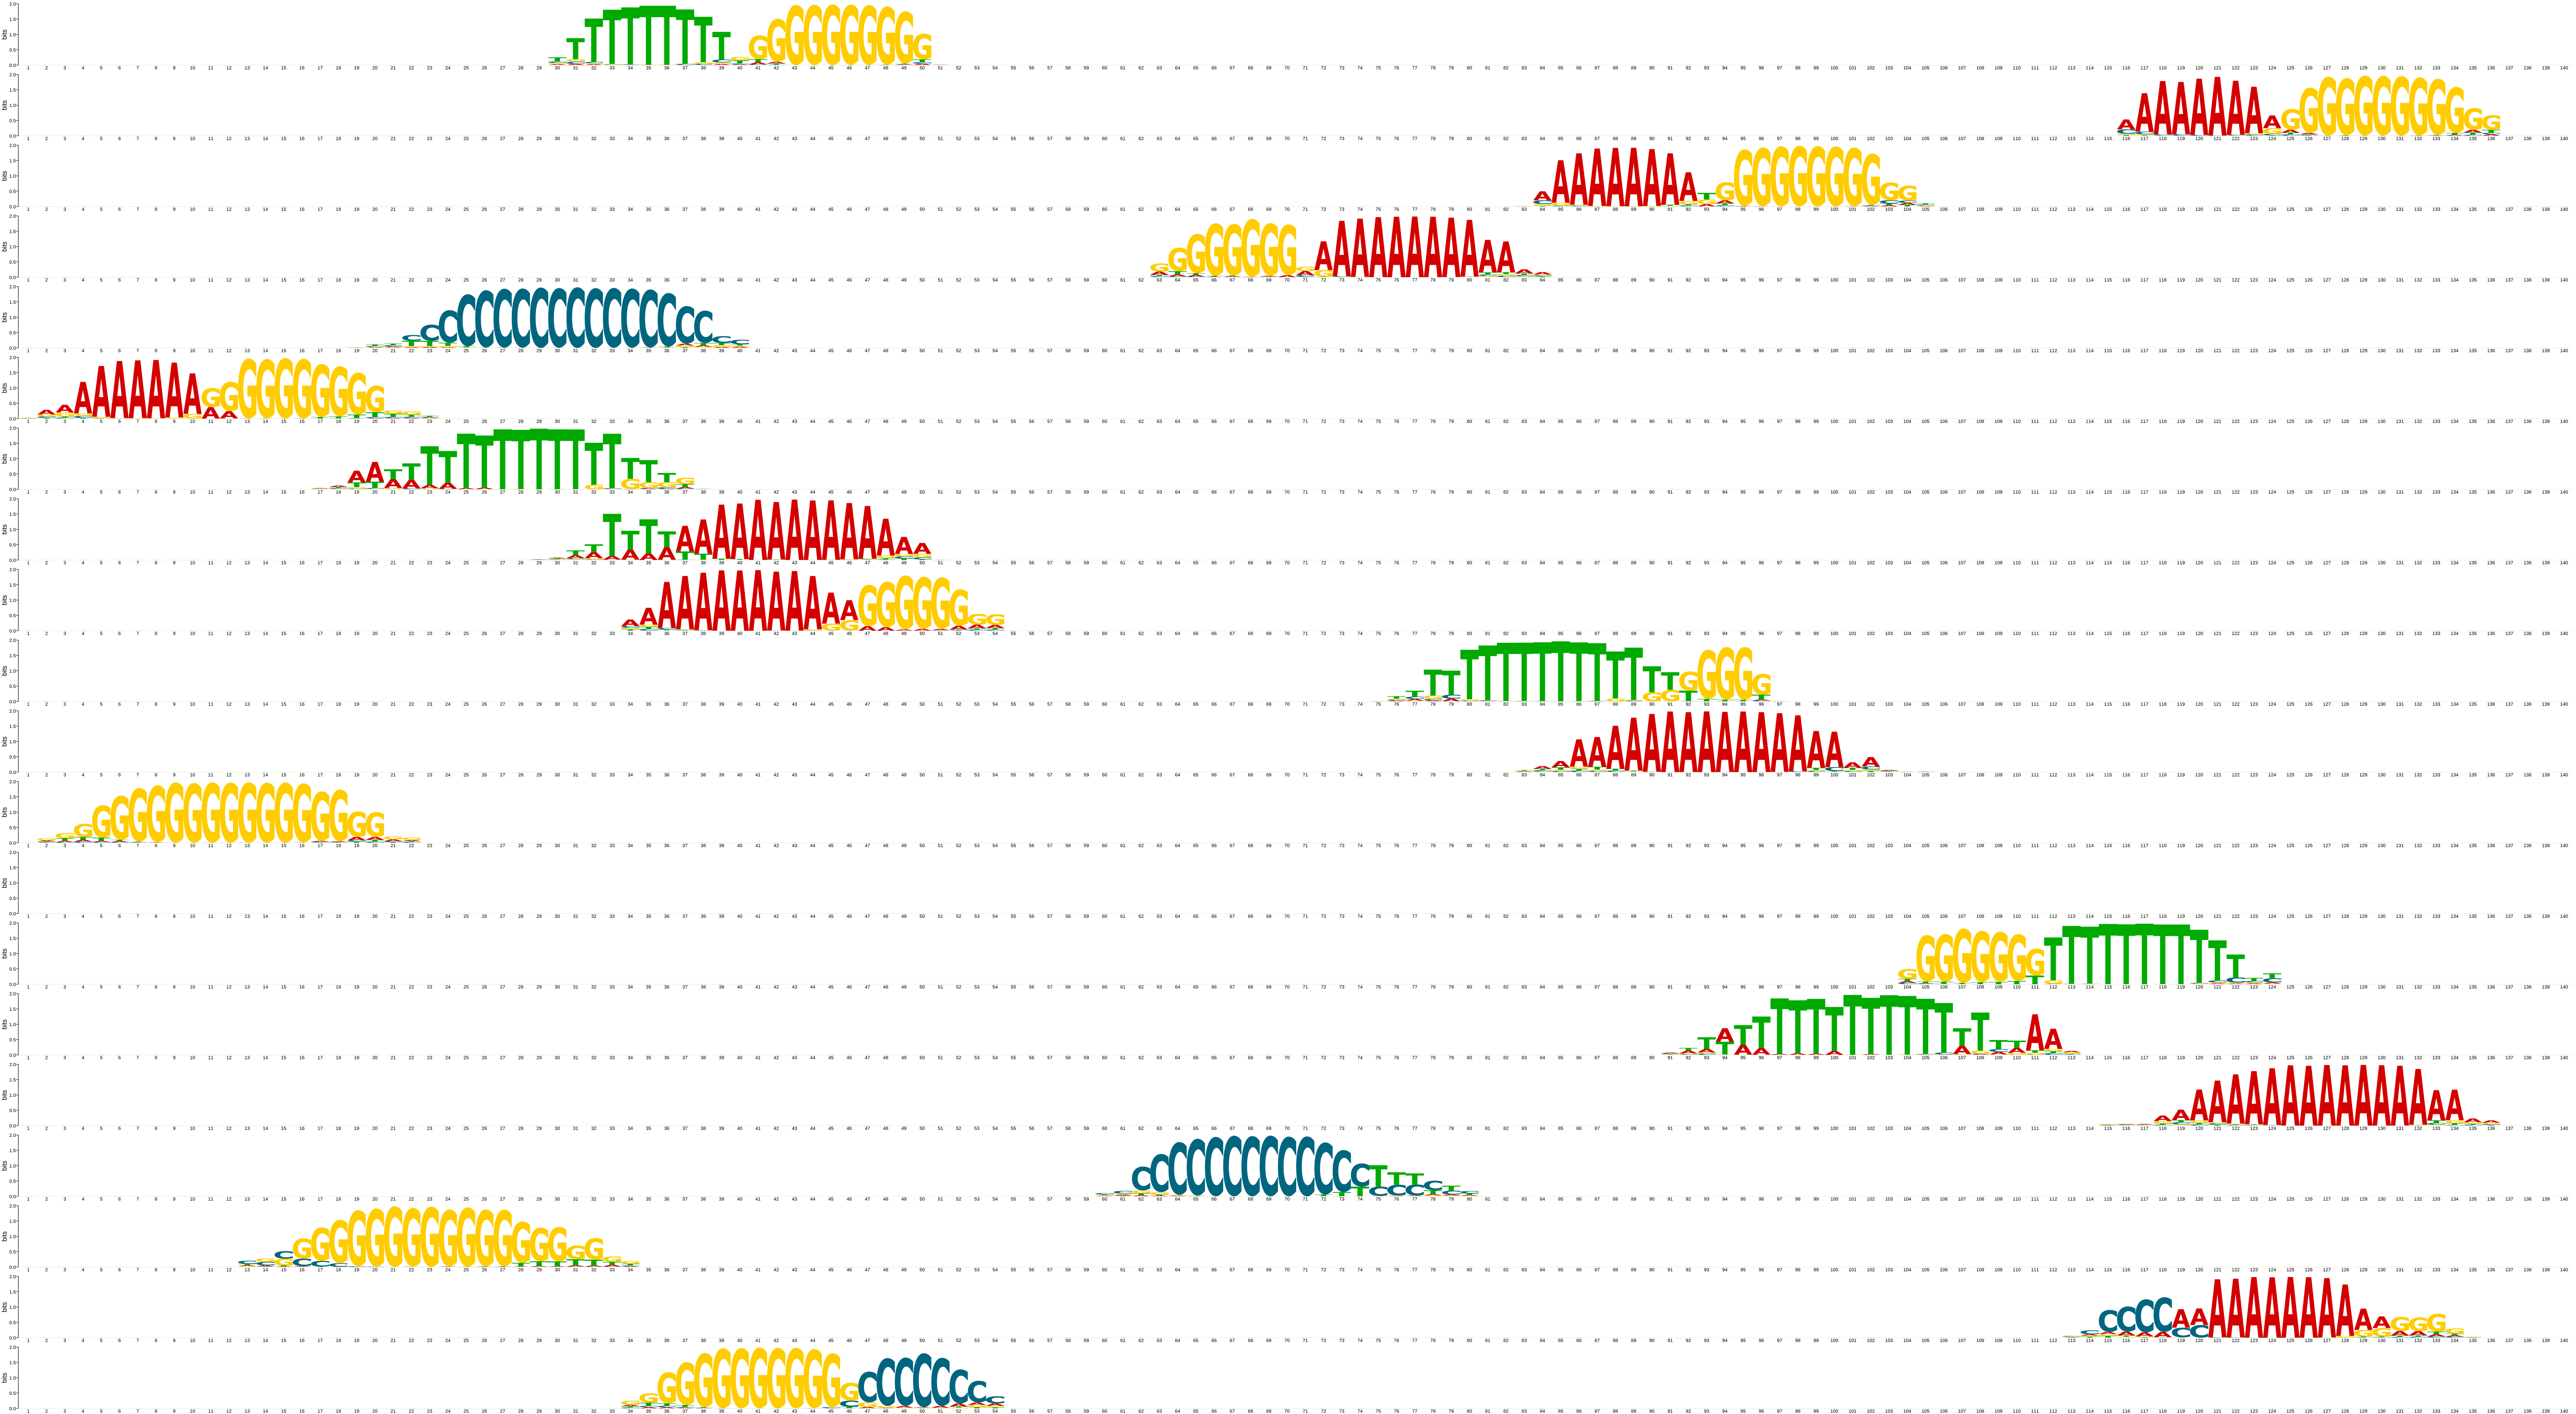

In [11]:
model.visualize_optimized_inputs(data, "conv1d_2", output_folder+'conv_2.png')
Image(output_folder+'conv_2.png')

The input to the second convolutional layer are the motifs from the first convolutional layer (with max-pooling in between), so we would expect the network to learn motif combinations or bigger motifs in this layer and this is exactly what we see in the above image. We see all kinds of combinations, even combinations of motifs that never co-occur in the data set like the T and G motif. Again, the network is not yet showing correct motif positions, rerunning the optimization yields the same motifs, but different positions (not shown)

## Visualization of the dense layer

Let's move on to our single dense layer with its 5 neurons (we had to use the bound parameter to avoid too many non-converging optimizations, have a look at the API documentation for more info):

Optimize node 0...
Optimize node 1...
Optimize node 2...
Optimize node 3...
Optimize node 4...


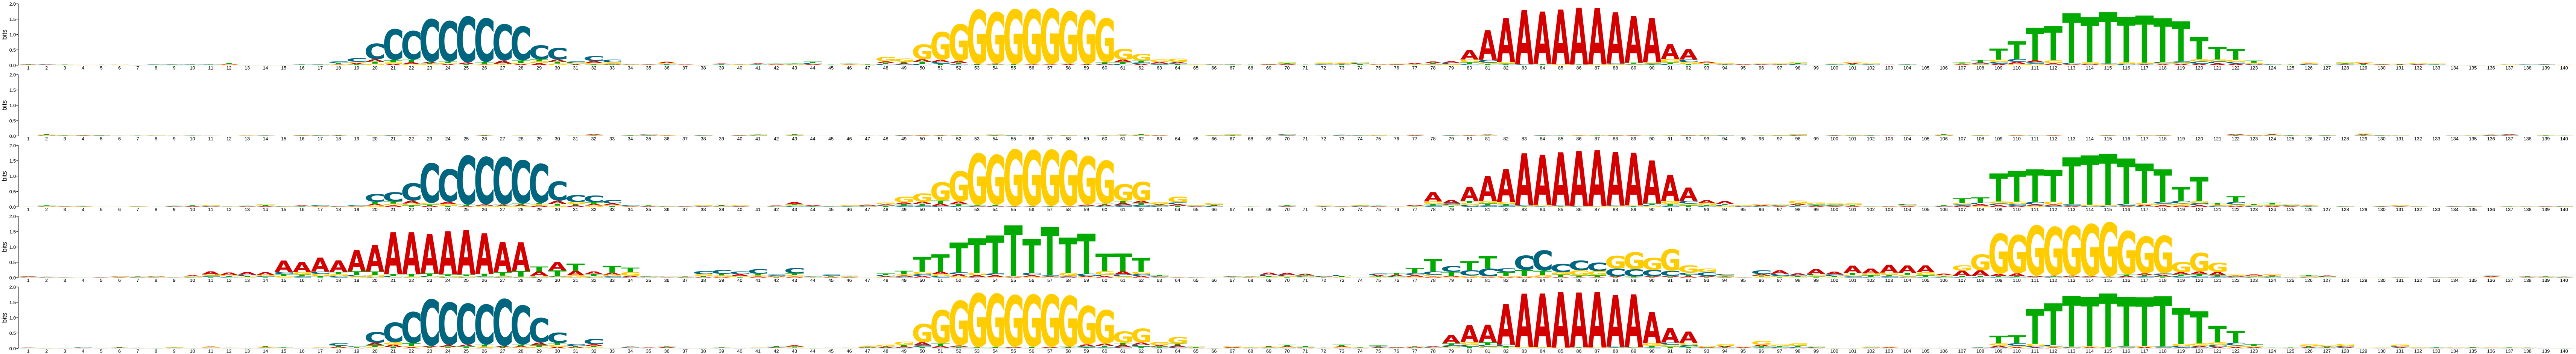

In [12]:
model.visualize_optimized_inputs(data, "dense_1", output_folder+'dense_1.png', bound=0.4)
Image(output_folder+'dense_1.png')

Each row in the output corresponds to one neuron and now we finally see exact motif positions. The inputs that maximize neuron 0, 2 and 4 actually look like an average class_0 sequence containing all 4 motifs. The input for neuron 3 has motifs at positions where we would expect a motif, but the actual motif is never the correct one. 

## Visualization of the output layer

To understand this, let's have a look at our final layer, the output layer:

Optimize node 0...
Optimize node 1...


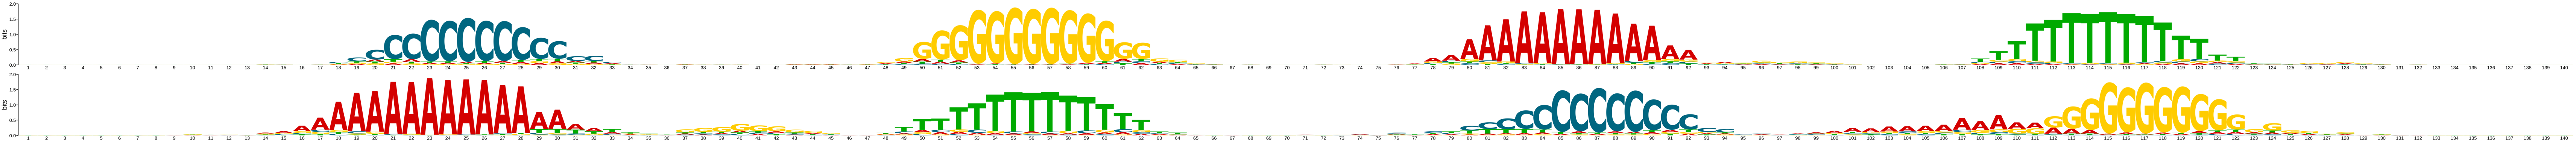

In [13]:
model.visualize_optimized_inputs(data, "dense_2", output_folder+'dense_2.png')
Image(output_folder+'dense_2.png')

The output layer has as many neurons as we have classes, 2 in this case. Therefore, neuron 0 represents class_0 and neuron 1 represents class_1. The input for neuron 0 looks again like an average class_0 sequence containing all 4 motifs. We probably already see the same neurons in the previous layer because this data set is extremly simple. 

The node representing class_1 shows a couple of motifs, even though class_1 sequences are completely random and do not contain motifs. Our explanation is that the network has to somehow model a class_1 sequence and it has to do so by using the motifs from class_0 and by arranging the motifs in a way that can't possibly form a class_0 sequence. The easiest way is apparently placing the motifs at the wrong positions...

And that is it. As said before, if somebody finds a way to apply this method to a noisy biological data set in a meaningful way, please let us know.

In [14]:
utils.save_data(data, output_folder+"data.pkl")
utils.save_model(model, output_folder+"model.pkl")